<a href="https://colab.research.google.com/github/shawng-lee/gpt2/blob/main/GPT2_tiny_shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets torch
!pip install accelerate -U
!pip install transformers -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 16.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

0. Import `dataset` from the tiny_shakespeare dataset

In [3]:
# Load tiny_shakespeare
from datasets import load_dataset

dataset = load_dataset("tiny_shakespeare", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

1. Initialize `tokenizer` to parse input text into tokens
2. Load `model`, a pretrained GPT2
3. Define `training_args`, training parameters
4. Tokenize `dataset` using `tokenizer`

In [4]:
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel
from transformers import TrainingArguments
from transformers import Trainer

# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

# Load GPT2
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.resize_token_embeddings(len(tokenizer)) # Resize the token embeddings in case you choose to add special tokens

# Define training parameters
training_args10 = TrainingArguments(
    output_dir='./results',          # Directory for saving trained model
    num_train_epochs=10,              # Number of training epochs
    per_device_train_batch_size=4,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps; the learning rate tends to be larger than the specified learning rate
    weight_decay=0.01,               # Weight decay to prevent overfitting; allow the weight to lose 1% of its memory, kind of like drop out layers
    logging_dir='./logs',            # Directory for storing logs
    logging_strategy="epoch",
    logging_steps=50,
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
    load_best_model_at_end=True      # Load the best model at the end of training
)

# use this function to tokenize the input
def tokenize_function(examples):
    # Tokenize the inputs and labels
    return tokenizer(examples['text'], max_length=512, truncation=True, padding="max_length")

tokenized_datasets= dataset.map(tokenize_function, batched=True, remove_columns=dataset['train'].column_names)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

5. Define `data_collator` and set to Causal Language Modeling (`mlm=False`). CLM uses preceding tokens to predict the next token. GPT-2 should **not** use Masked Language Modeling (MLM).

In [5]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

6. Define `trainer` which takes in all the objects we've defined in steps 0 to 5.
7. Begin training with the `train()` method for 10 epochs.

In [6]:
from transformers import Trainer

trainer10 = Trainer(
    model=model,
    args=training_args10,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
)

trainer10.train()

Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.976779
3,4.420500,3.972077
4,4.576400,3.965246
5,4.331000,3.955880
6,4.383500,3.944099
7,4.358700,3.929913
8,4.107700,3.913486
9,4.286300,3.894583
10,4.223600,3.873143


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=10, training_loss=4.322913885116577, metrics={'train_runtime': 121.9135, 'train_samples_per_second': 0.082, 'train_steps_per_second': 0.082, 'total_flos': 2612920320000.0, 'train_loss': 4.322913885116577, 'epoch': 10.0})

Save the trained model as *gpt2_tinys_10epoch*

In [7]:
from google.colab import drive
drive.mount('/content/drive')
model.save_pretrained('/content/drive/MyDrive/colab-models/gpt2_tinys_10epoch')

Mounted at /content/drive


8. Repeat training for 30 epochs.

In [8]:
# Define training parameters
training_args30 = TrainingArguments(
    output_dir='./results',          # Directory for saving trained model
    num_train_epochs=30,             # Number of training epochs
    per_device_train_batch_size=4,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps; the learning rate tends to be larger than the specified learning rate
    weight_decay=0.01,               # Weight decay to prevent overfitting; allow the weight to lose 1% of its memory, kind of like drop out layers
    logging_dir='./logs',            # Directory for storing logs
    logging_strategy="epoch",
    logging_steps=50,
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
    load_best_model_at_end=True      # Load the best model at the end of training
)

from transformers import Trainer

trainer30 = Trainer(
    model=model,
    args=training_args30,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
)

trainer30.train()

Epoch,Training Loss,Validation Loss
1,4.187500,3.873143
2,4.185200,3.870722
3,4.306200,3.865960
4,4.498000,3.858860
5,4.235000,3.849262
6,4.267900,3.837506
7,4.260900,3.823532
8,3.997200,3.807889
9,4.182900,3.790226
10,4.139500,3.771056


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=30, training_loss=4.05743682384491, metrics={'train_runtime': 334.7297, 'train_samples_per_second': 0.09, 'train_steps_per_second': 0.09, 'total_flos': 7838760960000.0, 'train_loss': 4.05743682384491, 'epoch': 30.0})

Save the trained model as *gpt2_tinys_30epoch*

In [9]:
model.save_pretrained('/content/drive/MyDrive/colab-models/gpt2_tinys_30epoch')

Plot the results:

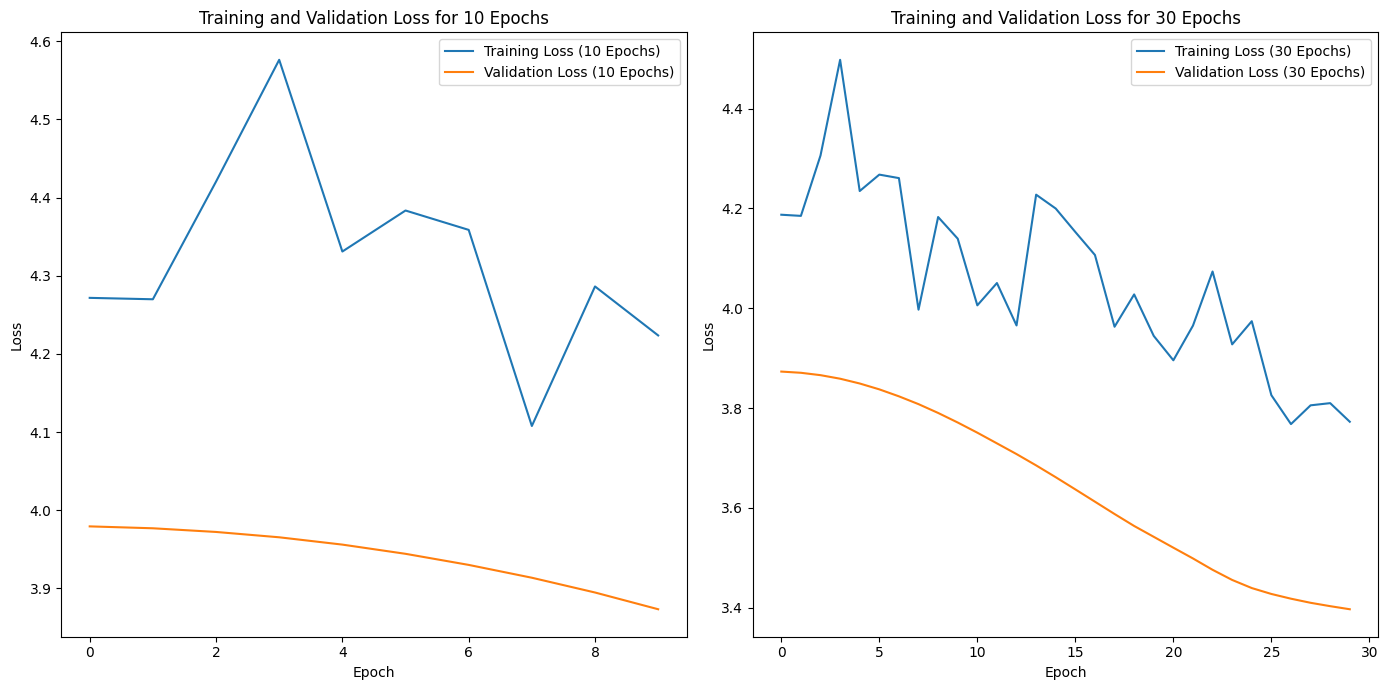

In [10]:
import matplotlib.pyplot as plt

def extract_loss(log_history, type_of_loss):
    """ Helper function to extract losses from the log history. """
    return [entry[type_of_loss] for entry in log_history if type_of_loss in entry]

# Extract losses for the first trainer (10 epochs)
train_loss_10 = extract_loss(trainer10.state.log_history, 'loss')
eval_loss_10 = extract_loss(trainer10.state.log_history, 'eval_loss')

# Extract losses for the second trainer (30 epochs)
train_loss_30 = extract_loss(trainer30.state.log_history, 'loss')
eval_loss_30 = extract_loss(trainer30.state.log_history, 'eval_loss')

# Plotting
plt.figure(figsize=(14, 7))

# Training and Validation Loss for 10 Epochs
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(train_loss_10, label='Training Loss (10 Epochs)')
plt.plot(eval_loss_10, label='Validation Loss (10 Epochs)')
plt.title('Training and Validation Loss for 10 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Loss for 30 Epochs
plt.subplot(1, 2, 2, sharey=ax1)  # 1 row, 2 columns, 2nd subplot
plt.plot(train_loss_30, label='Training Loss (30 Epochs)')
plt.plot(eval_loss_30, label='Validation Loss (30 Epochs)')
plt.title('Training and Validation Loss for 30 Epochs')
plt.xlabel('Epoch')
# plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


You can load the trained model as `model2` to GPU

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model10 = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/colab-models/gpt2_tinys_10epoch').to(device)
model30 = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/colab-models/gpt2_tinys_30epoch').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


8. Define text inputs: `prompt1` and `prompt2`
9. Tokenize `promptX` as `input_idsX`
10. Pass `input_dsX` to `model2` to generate `outputX`
11. Get natural language output `generated_textX` by applying `tokenizer.decode(outputX[0])`

In [21]:
tokenizer.pad_token = tokenizer.eos_token

# Prepare input text
prompt1 = "To be or not to be"
prompt2 = "A horse! a horse! my kingdom for a horse!"

# Encode the input text and send to the same device
input_ids1 = tokenizer.encode(prompt1, return_tensors='pt').to(device)
input_ids2 = tokenizer.encode(prompt2, return_tensors='pt').to(device)

# Generate text
model_output1 = model.generate(input_ids1, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)
model_output2 = model.generate(input_ids2, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)

model10_output1 = model10.generate(input_ids1, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)
model10_output2 = model10.generate(input_ids2, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)

model30_output1 = model30.generate(input_ids1, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)
model30_output2 = model30.generate(input_ids2, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)

# Decode the generated text
model_generated_text1 = tokenizer.decode(model_output1[0], skip_special_tokens=True)
model_generated_text2 = tokenizer.decode(model_output2[0], skip_special_tokens=True)

model10_generated_text1 = tokenizer.decode(model10_output1[0], skip_special_tokens=True)
model10_generated_text2 = tokenizer.decode(model10_output2[0], skip_special_tokens=True)

model30_generated_text1 = tokenizer.decode(model30_output1[0], skip_special_tokens=True)
model30_generated_text2 = tokenizer.decode(model30_output2[0], skip_special_tokens=True)

print("===========================")
print('No fine-tuning output:')
print(model_generated_text1)
print()
print('10 epoch output:')
print(model10_generated_text1)
print()
print('30 epoch output:')
print(model30_generated_text1)

print("===========================")
print('No fine-tuning output:')
print(model_generated_text2)
print()
print('10 epoch output:')
print(model10_generated_text2)
print()
print('30 epoch output:')
print(model30_generated_text2)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:535: UserWarning:

`num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.



No fine-tuning output:
To be or not to be, the only thing that matters is that you're a good person.

I'm not saying that I'm a bad person, but I am saying I don't want to become a better person than I already am. I want people to know that they're not alone. They're part of the problem. And I think that's what we need to do. We need people who are willing to take responsibility for themselves. That's the way we're going to

10 epoch output:
To be or not to be, the only thing that matters is that you're a good person.

I'm not saying that I'm a bad person, but I am saying I don't want to become a better person than I already am. I want people to know that they're not alone. They're part of the problem. And I think that's what we need to do. We need people who are willing to take responsibility for themselves. That's the way we're going to

30 epoch output:
To be or not to be, the only thing that matters is that you're a good person.

I'm not saying that I'm a bad person, but I am sayin

Perform some hyperparameter tuning:

In [14]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 12.9 MB/s eta 0:00:00


In [15]:
import optuna
from transformers import Trainer, TrainingArguments

def objective(trial):
    model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

    # Define hyperparameters using trial object
    weight_decay = trial.suggest_float("weight_decay", 0.01, 0.1)
    train_batch_size = trial.suggest_categorical("train_batch_size", [4, 8, 10])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=10,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=weight_decay,
        learning_rate=learning_rate,
        logging_dir='./logs',
        logging_strategy="epoch",
        logging_steps=50,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['test'],
        data_collator=data_collator,
    )

    # Training and evaluation
    trainer.train()
    eval_result = trainer.evaluate()

    # Optuna aims to minimize the objective, so if another metric is used that should be maximized,
    # you should return its negative value
    return eval_result["eval_loss"]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # You can specify the number of trials

print("Best trial:")
trial_ = study.best_trial

print(f"  Value: {trial_.value}")
print("  Params: ")
for key, value in trial_.params.items():
    print(f"    {key}: {value}")


[I 2024-05-11 21:58:51,149] A new study created in memory with name: no-name-25d39a6e-1d5c-4f29-b9cb-91538e89cb8c
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.978274
3,4.421800,3.976472
4,4.579000,3.973870
5,4.337900,3.970309
6,4.397000,3.965852
7,4.376600,3.960494
8,4.137300,3.954266
9,4.323700,3.947075
10,4.267400,3.938853


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:00:56,325] Trial 0 finished with value: 3.9388530254364014 and parameters: {'weight_decay': 0.041725947279299014, 'train_batch_size': 8, 'learning_rate': 1.9234254980800043e-05}. Best is trial 0 with value: 3.9388530254364014.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.978144
3,4.421700,3.976096
4,4.578800,3.973150
5,4.337300,3.969122
6,4.395900,3.964074
7,4.375100,3.958002
8,4.134800,3.950949
9,4.320600,3.942801
10,4.263700,3.933493


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:03:30,184] Trial 1 finished with value: 3.9334933757781982 and parameters: {'weight_decay': 0.03460546470226708, 'train_batch_size': 8, 'learning_rate': 2.1748700507512795e-05}. Best is trial 1 with value: 3.9334933757781982.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.976655
3,4.420400,3.971715
4,4.576200,3.964543
5,4.330500,3.954704
6,4.382400,3.942334
7,4.357200,3.927444
8,4.105300,3.910192
9,4.283300,3.890367
10,4.220200,3.867899


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:05:22,286] Trial 2 finished with value: 3.86789870262146 and parameters: {'weight_decay': 0.092598582821755, 'train_batch_size': 10, 'learning_rate': 5.245651041752457e-05}. Best is trial 2 with value: 3.86789870262146.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.973614
3,4.417600,3.962718
4,4.570900,3.946789
5,4.316500,3.924901
6,4.354200,3.897533
7,4.320100,3.864724
8,4.046700,3.827876
9,4.208300,3.786745
10,4.139800,3.744354


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:08:00,478] Trial 3 finished with value: 3.7443535327911377 and parameters: {'weight_decay': 0.03667265777040646, 'train_batch_size': 8, 'learning_rate': 0.00011489403914396873}. Best is trial 3 with value: 3.7443535327911377.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.978231
3,4.421800,3.976337
4,4.578900,3.973591
5,4.337600,3.969851
6,4.396600,3.965158
7,4.376000,3.959515
8,4.136300,3.952966
9,4.322500,3.945393
10,4.265900,3.936742


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:10:56,894] Trial 4 finished with value: 3.936741828918457 and parameters: {'weight_decay': 0.0872959400858901, 'train_batch_size': 10, 'learning_rate': 2.0230361237694408e-05}. Best is trial 3 with value: 3.7443535327911377.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.978087
3,4.421700,3.975921
4,4.578600,3.972781
5,4.337000,3.968482
6,4.395300,3.963099
7,4.374300,3.956619
8,4.133500,3.949095
9,4.318800,3.940402
10,4.261600,3.930478


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:14:05,560] Trial 5 finished with value: 3.9304778575897217 and parameters: {'weight_decay': 0.020215118155501886, 'train_batch_size': 8, 'learning_rate': 2.3174724306180167e-05}. Best is trial 3 with value: 3.7443535327911377.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.974863
3,4.418700,3.966434
4,4.573100,3.954142
5,4.322300,3.937252
6,4.365900,3.916068
7,4.335500,3.890588
8,4.070400,3.861460
9,4.239100,3.828423
10,4.171800,3.791996


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:17:13,290] Trial 6 finished with value: 3.7919955253601074 and parameters: {'weight_decay': 0.05102285451651617, 'train_batch_size': 4, 'learning_rate': 8.910135315104581e-05}. Best is trial 3 with value: 3.7443535327911377.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.972932
3,4.416900,3.960701
4,4.569800,3.942798
5,4.313300,3.918218
6,4.347900,3.887529
7,4.311700,3.850869
8,4.034300,3.810095
9,4.192000,3.765665
10,4.123300,3.720789


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:20:09,175] Trial 7 finished with value: 3.7207889556884766 and parameters: {'weight_decay': 0.09450033171471726, 'train_batch_size': 8, 'learning_rate': 0.00012879730551020242}. Best is trial 7 with value: 3.7207889556884766.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.957576
3,4.402800,3.914949
4,4.541900,3.852675
5,4.241500,3.772014
6,4.217600,3.688517
7,4.134300,3.605502
8,3.854000,3.532856
9,3.906700,3.461630
10,3.899200,3.416400


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:24:04,676] Trial 8 finished with value: 3.4163999557495117 and parameters: {'weight_decay': 0.0321520735326736, 'train_batch_size': 4, 'learning_rate': 0.0004400367743212597}. Best is trial 8 with value: 3.4163999557495117.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.978439
3,4.422000,3.976945
4,4.579200,3.974784
5,4.338600,3.971824
6,4.398500,3.968121
7,4.378400,3.963669
8,4.140400,3.958500
9,4.327700,3.952529
10,4.272200,3.945699


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:27:12,286] Trial 9 finished with value: 3.9456989765167236 and parameters: {'weight_decay': 0.08970190288853896, 'train_batch_size': 8, 'learning_rate': 1.602475584564114e-05}. Best is trial 8 with value: 3.4163999557495117.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.964668
3,4.409300,3.936116
4,4.555100,3.894184
5,4.274900,3.837393
6,4.273900,3.770837
7,4.212800,3.701970
8,3.912600,3.634793
9,4.013700,3.568481
10,3.983200,3.508122


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:30:21,473] Trial 10 finished with value: 3.508122205734253 and parameters: {'weight_decay': 0.0660198891539396, 'train_batch_size': 4, 'learning_rate': 0.00029668416688753436}. Best is trial 8 with value: 3.4163999557495117.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.957194
3,4.402500,3.913814
4,4.541200,3.850463
5,4.239700,3.768765
6,4.214800,3.684431
7,4.130200,3.600965
8,3.851500,3.528190
9,3.901900,3.456832
10,3.895000,3.413951


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:33:38,555] Trial 11 finished with value: 3.4139513969421387 and parameters: {'weight_decay': 0.06027465828135735, 'train_batch_size': 4, 'learning_rate': 0.0004477132661379196}. Best is trial 11 with value: 3.4139513969421387.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.959217
3,4.404300,3.919847
4,4.545000,3.862219
5,4.249200,3.786390
6,4.229900,3.706521
7,4.152300,3.625504
8,3.865400,3.553693
9,3.928300,3.484071
10,3.917200,3.427744


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:36:45,583] Trial 12 finished with value: 3.427743673324585 and parameters: {'weight_decay': 0.06368453463978288, 'train_batch_size': 4, 'learning_rate': 0.0004069404394211206}. Best is trial 11 with value: 3.4139513969421387.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.967642
3,4.412100,3.944980
4,4.560400,3.911687
5,4.288800,3.866233
6,4.299900,3.811166
7,4.247700,3.750478
8,3.949200,3.690170
9,4.071500,3.628003
10,4.023100,3.569964


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:40:22,243] Trial 13 finished with value: 3.5699644088745117 and parameters: {'weight_decay': 0.01591375428734096, 'train_batch_size': 4, 'learning_rate': 0.00023643378105964063}. Best is trial 11 with value: 3.4139513969421387.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.956345
3,4.401700,3.911277
4,4.539600,3.845544
5,4.235700,3.761606
6,4.208600,3.675426
7,4.121200,3.591001
8,3.846000,3.517999
9,3.891400,3.446976
10,3.885600,3.408596


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:44:05,853] Trial 14 finished with value: 3.408595561981201 and parameters: {'weight_decay': 0.06605261933159236, 'train_batch_size': 4, 'learning_rate': 0.0004648724203406848}. Best is trial 14 with value: 3.408595561981201.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.970003
3,4.414200,3.952004
4,4.564600,3.925579
5,4.299800,3.889374
6,4.321100,3.844780
7,4.276000,3.792908
8,3.984900,3.739892
9,4.123300,3.684561
10,4.061200,3.629262


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:47:55,308] Trial 15 finished with value: 3.6292619705200195 and parameters: {'weight_decay': 0.0759407958866874, 'train_batch_size': 4, 'learning_rate': 0.0001885336999650187}. Best is trial 14 with value: 3.408595561981201.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.976887
3,4.420600,3.972376
4,4.576600,3.965830
5,4.331500,3.956854
6,4.384400,3.945564
7,4.359900,3.931970
8,4.109700,3.916220
9,4.288800,3.898092
10,4.226400,3.877517


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:51:15,132] Trial 16 finished with value: 3.877516508102417 and parameters: {'weight_decay': 0.07447556572007427, 'train_batch_size': 4, 'learning_rate': 4.7951612439477884e-05}. Best is trial 14 with value: 3.408595561981201.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.970757
3,4.414900,3.954249
4,4.566000,3.930027
5,4.303300,3.896818
6,4.328000,3.855737
7,4.285200,3.807523
8,3.997100,3.756791
9,4.141000,3.704516
10,4.075700,3.651005


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:54:54,271] Trial 17 finished with value: 3.651005268096924 and parameters: {'weight_decay': 0.055087348551588054, 'train_batch_size': 4, 'learning_rate': 0.0001731325143555705}. Best is trial 14 with value: 3.408595561981201.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.963406
3,4.408200,3.932346
4,4.552800,3.886732
5,4.268900,3.825280
6,4.263200,3.754985
7,4.198300,3.682526
8,3.900000,3.613878
9,3.991800,3.546332
10,3.966400,3.484603


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 22:57:48,855] Trial 18 finished with value: 3.4846034049987793 and parameters: {'weight_decay': 0.05404514089035833, 'train_batch_size': 10, 'learning_rate': 0.000322341149817555}. Best is trial 14 with value: 3.408595561981201.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<ipython-input-15-800727399372>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)


Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.954626
3,4.400100,3.906176
4,4.536300,3.835684
5,4.227700,3.747654
6,4.196300,3.657883
7,4.103700,3.571727
8,3.835600,3.498429
9,3.871200,3.431339
10,3.866900,3.399956


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


[I 2024-05-11 23:01:18,706] Trial 19 finished with value: 3.399955987930298 and parameters: {'weight_decay': 0.07156419822220642, 'train_batch_size': 4, 'learning_rate': 0.0004992945476952409}. Best is trial 19 with value: 3.399955987930298.


Best trial:
  Value: 3.399955987930298
  Params: 
    weight_decay: 0.07156419822220642
    train_batch_size: 4
    learning_rate: 0.0004992945476952409


In [17]:
import optuna.visualization as optuna_viz

optuna_viz.plot_contour(study, params=['weight_decay', 'learning_rate'])

In [18]:
optuna_viz.plot_contour(study, params=['train_batch_size', 'learning_rate'])

In [19]:
optuna_viz.plot_contour(study, params=['weight_decay', 'train_batch_size'])

Retrain with optimal parameters

In [25]:
best_params = study.best_trial.params
print("Optimal Hyperparameters:", best_params)

from transformers import TrainingArguments, Trainer, GPT2LMHeadModel

# Define training parameters with Optuna's best parameters
training_args_best = TrainingArguments(
    output_dir='./results',          # Directory for saving trained model
    num_train_epochs=30,             # Increase the number of training epochs for further training
    per_device_train_batch_size=best_params['train_batch_size'],   # Optimal batch size
    per_device_eval_batch_size=8,    # Evaluation batch size remains constant
    warmup_steps=500,                # Warmup steps, consider optimizing this as well
    weight_decay=best_params['weight_decay'],  # Optimal weight decay
    learning_rate=best_params['learning_rate'],  # Optimal learning rate
    logging_dir='./logs',            # Directory for storing logs
    logging_strategy="epoch",
    logging_steps=50,
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
    load_best_model_at_end=True      # Load the best model at the end of training
)

# Assume the model is reloaded or retained in memory from before
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)  # Ensure the model is loaded appropriately

Optimal Hyperparameters: {'weight_decay': 0.07156419822220642, 'train_batch_size': 4, 'learning_rate': 0.0004992945476952409}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [26]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

# Initialize Trainer with the best training arguments
trainer_best = Trainer(
    model=model,
    args=training_args_best,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# Train the model with the best hyperparameters
trainer_best.train()

Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.954626
3,4.400100,3.906176
4,4.536300,3.835684
5,4.227700,3.747654
6,4.196300,3.657883
7,4.103700,3.571727
8,3.835600,3.498429
9,3.871200,3.431339
10,3.866900,3.399956


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=17, training_loss=3.952915472142837, metrics={'train_runtime': 215.1154, 'train_samples_per_second': 0.139, 'train_steps_per_second': 0.139, 'total_flos': 4441964544000.0, 'train_loss': 3.952915472142837, 'epoch': 17.0})

In [27]:
model.save_pretrained('/content/drive/MyDrive/colab-models/gpt2_tinys_finetuned')

In [28]:
model_tuned = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/colab-models/gpt2_tinys_finetuned').to(device)

In [29]:
tokenizer.pad_token = tokenizer.eos_token

# Prepare input text
prompt1 = "To be or not to be"
prompt2 = "A horse! a horse! my kingdom for a horse!"

# Encode the input text and send to the same device
input_ids1 = tokenizer.encode(prompt1, return_tensors='pt').to(device)
input_ids2 = tokenizer.encode(prompt2, return_tensors='pt').to(device)

# Generate text
model_output1 = model.generate(input_ids1, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)
model_output2 = model.generate(input_ids2, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)

model10_output1 = model10.generate(input_ids1, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)
model10_output2 = model10.generate(input_ids2, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)

model30_output1 = model30.generate(input_ids1, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)
model30_output2 = model30.generate(input_ids2, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)

model_tuned_output1 = model_tuned.generate(input_ids1, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)
model_tuned_output2 = model_tuned.generate(input_ids2, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=tokenizer.pad_token_id)

# Decode the generated text
model_generated_text1 = tokenizer.decode(model_output1[0], skip_special_tokens=True)
model_generated_text2 = tokenizer.decode(model_output2[0], skip_special_tokens=True)

model10_generated_text1 = tokenizer.decode(model10_output1[0], skip_special_tokens=True)
model10_generated_text2 = tokenizer.decode(model10_output2[0], skip_special_tokens=True)

model30_generated_text1 = tokenizer.decode(model30_output1[0], skip_special_tokens=True)
model30_generated_text2 = tokenizer.decode(model30_output2[0], skip_special_tokens=True)

model_tuned_generated_text1 = tokenizer.decode(model_tuned_output1[0], skip_special_tokens=True)
model_tuned_generated_text2 = tokenizer.decode(model_tuned_output2[0], skip_special_tokens=True)

print("===========================")
print('No fine-tuning output:')
print(model_generated_text1)
print()
print('10 epoch output:')
print(model10_generated_text1)
print()
print('30 epoch output:')
print(model30_generated_text1)
print()
print('fine-tuned output:')
print(model_tuned_generated_text1)

print("===========================")
print('No fine-tuning output:')
print(model_generated_text2)
print()
print('10 epoch output:')
print(model10_generated_text2)
print()
print('30 epoch output:')
print(model30_generated_text2)
print()
print('fine-tuned output:')
print(model_tuned_generated_text2)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:535: UserWarning:

`num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.



No fine-tuning output:
To be or not to be, the only thing that matters is that you're a good person.

I'm not saying that I'm a bad person, but I am saying I don't think I should be judged by my actions. I think that if I were to do something that was wrong, I would be punished. If I was to say something I didn't like, that would not be my fault. But if it was something you did wrong and you didn. That's not

10 epoch output:
To be or not to be, the only thing that matters is that you're a good person.

I'm not saying that I'm a bad person, but I am saying I don't want to become a better person than I already am. I want people to know that they're not alone. They're part of the problem. And I think that's what we need to do. We need people who are willing to take responsibility for themselves. That's the way we're going to

30 epoch output:
To be or not to be, the only thing that matters is that you're a good person.

I'm not saying that I'm a bad person, but I am saying I don't want t

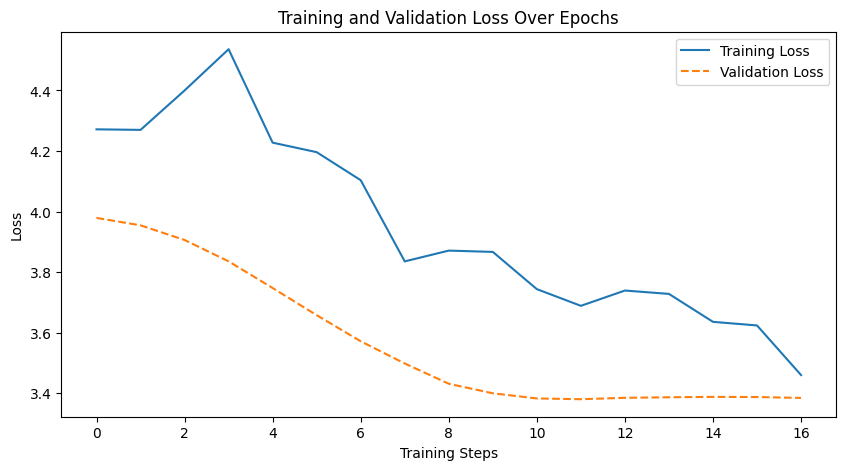

In [30]:
def extract_loss(log_history, type_of_loss):
    """ Helper function to extract losses from the log history. """
    return [entry[type_of_loss] for entry in log_history if type_of_loss in entry]

# Extract training and validation loss from the trainer's log history
train_loss = extract_loss(trainer_best.state.log_history, 'loss')
eval_loss = extract_loss(trainer_best.state.log_history, 'eval_loss')

# Check if eval loss is logged at different steps, and adjust the x-axis for eval_loss if necessary
if len(train_loss) != len(eval_loss):
    # Assuming evals are less frequent
    eval_indices = [i * (len(train_loss) // len(eval_loss)) for i in range(len(eval_loss))]
else:
    eval_indices = list(range(len(eval_loss)))

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_indices, eval_loss, label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()
